<a href="https://colab.research.google.com/github/Fernando123Duran/Asistente_Composici-n_musical/blob/main/Notbooks/sprint_2/2_gptmin_compositor_musical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/Colab/proyecto_perfil/modelo'

Mounted at /gdrive
/gdrive/My Drive/Colab/proyecto_perfil/modelo


In [ ]:
%cd minGPT

/gdrive/My Drive/Colab/proyecto_perfil/modelo/minGPT


In [ ]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///gdrive/My%20Drive/Colab/proyecto_perfil/modelo/minGPT
  Running setup.py develop for minGPT


In [ ]:
# Ejecutar solo la primera vez cuando se prepara el entorno de trabajo
# !git clone https://github.com/karpathy/minGPT.git 

Cloning into 'minGPT'...
remote: Enumerating objects: 486, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 486 (delta 101), reused 160 (delta 88), pack-reused 291
Receiving objects: 100% (486/486), 1.46 MiB | 8.01 MiB/s, done.
Resolving deltas: 100% (256/256), done.


In [ ]:
!pip list

In [ ]:
import torch
import numpy as np
import json

In [ ]:

def cargarArchivosNPY(path):
    with open(path, 'rb') as f:
        datos = np.load(f,allow_pickle=True)
    return datos 

def cargarVocabulario(pathVocabulario):
    with open(pathVocabulario, "r") as fp:
        mappings = json.load(fp)
    return mappings

In [ ]:
vocab=cargarVocabulario("../../vocabulario/vocabulario2022.json")
len(vocab)

141

In [ ]:
vocabReves=cargarVocabulario("../../vocabulario/vocabulario_inverso_2022.json")
len(vocab)

141

In [ ]:
datos=cargarArchivosNPY("../../archivos_numpy/partituras_tinku_23.npy")


In [ ]:
datosCompletos=[]
datos=datos.tolist()
for da in datos:
  datosCompletos.append(np.array(datos[da]))

datosCompletos[0]

array([  1,  51,  47,  38, 107,   3, 111,   4, 111,   3,  19, 111,   3,
        21, 111,   4, 109,   3, 111,   4, 109,   4, 111,   3, 109,   3,
       111,   3, 113,   3, 114,   8,  26,   4, 106,   3, 109,   4, 109,
         3,  19, 109,   3,  21, 109,   4, 111,   3, 109,   5, 104,   3,
       106,   3, 104,   3, 103,   3, 106,   3, 104,   6,  26,   6,  30,
        29, 104,   3, 107,   4, 107,   3,  19, 107,   3,  21, 107,   4,
       106,   3, 107,   4, 106,   4, 107,   3, 106,   3, 107,   3, 109,
         3, 111,   8,  26,   4, 106,   3, 109,   4, 109,   3,  19, 109,
         3,  21, 109,   4, 111,   3, 109,   5, 106,   3, 106,   3, 104,
         3, 103,   3, 106,   3,  22,  27, 104,   8,  26,   4,  30,  23,
        27,  24, 104,   5, 111,   3,  19, 111,   3,  21, 111,   4, 109,
         3,  27,  25,  29, 111,   3, 111,   4, 109,   3, 111,   5, 109,
         3, 111,   8,  26,   4, 106,   3, 109,   4, 109,   3,  19, 109,
         3,  21, 109,   4, 111,   3, 109,   5, 106,   3, 106,   

In [ ]:
# datos= datos.tolist()
# datos=np.array(datos)
# datos

In [ ]:
!ls 

demo.ipynb  generate.ipynb  mingpt	     mingpt.jpg  README.md  tests
font.sf2    LICENSE	    minGPT.egg-info  projects	 setup.py


In [ ]:
# datoPrueba= datos.tolist()
# datoPrueba=np.array(datoPrueba["0"])
# len(datoPrueba)

341

In [ ]:

class Dataset(torch.utils.data.Dataset):

  def __init__(self, examples,sizeBlock):
    self.examples = examples
    self.sizeBlock = sizeBlock

  def __len__(self):
    return len(self.examples)
   
  def __getitem__(self, ix):
    dato=self.examples[ix]
    entrada=dato[:-1]
    salida = dato[1:]
    input = np.pad(entrada, (0,self.sizeBlock-len(entrada)), 'constant', constant_values=0)
    target = np.pad(salida, (0,self.sizeBlock-len(salida)), 'constant', constant_values=0)
    assert len(input) == self.sizeBlock
    assert len(target) == self.sizeBlock

    return torch.LongTensor(input), torch.LongTensor(target)

In [ ]:
from sklearn.model_selection import train_test_split
class DataModuleLinghtning(pl.LightningDataModule):
  def __init__(self, pathDatos="../../archivos_numpy/dataAumentation.npy",batch_size=25):
    self.pathDatos=pathDatos
    self.batch_size=batch_size
    self.entre=None
    self.valid=None

  def setup(self,stage=None):
    with open(self.pathDatos, 'rb') as f:
      datos = np.load(f,allow_pickle=True)
    datosCompletos=[]
    datos=datos.tolist()
    for da in datos:
      datosCompletos.append(np.array(datos[da]))
    entrep, validp= train_test_split(datosCompletos, shuffle=True,train_size=0.9)
    self.entre=Dataset(examples=entrep,sizeBlock=768)
    self.valid=Dataset(examples=validp,sizeBlock=768)

  def train_dataloader(self):
    return torch.utils.data.DataLoader(self.entre, batch_size=self.batch_size, shuffle=True, pin_memory=True)
  
  def valid_dataloader(self):
    return torch.utils.data.DataLoader(self.valid, batch_size=self.batch_size, shuffle=False, pin_memory=True)
    


In [ ]:
dataSetEntre=DataModuleLinghtning()
dataSetEntre.setup()

In [ ]:
# instanciaDataset=Dataset(datosCompletos,1024)
# input,target=instanciaDataset[0]
# print(input)


tensor([ 1, 51, 47,  ...,  0,  0,  0])


In [ ]:
# print(target)

In [ ]:
dl = torch.utils.data.DataLoader(instanciaDataset, batch_size=2, shuffle=False)

x, y = next(iter(dl))
x.shape, y.shape

(torch.Size([2, 1024]), torch.Size([2, 1024]))

In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 36.7 MB/s 
     |████████████████████████████████| 529 kB 70.5 MB/s 
     |████████████████████████████████| 125 kB 66.1 MB/s 
     |████████████████████████████████| 87 kB 7.3 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=abcfd2ecf2b9fb6036f43602332933210c3a91595790970ef18852b6a57ab113
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [ ]:
from mingpt.model import GPT
from mingpt.trainer import Trainer
class Module(pl.LightningModule):
	def __init__(self):
		super().__init__()
		model_config = GPT.get_default_config()
		model_config.model_type = 'gpt2'
		model_config.vocab_size =len(vocab) # openai's model vocabulary
		model_config.block_size = 768
		train_config = Trainer.get_default_config()
		train_config.learning_rate = 5e-4 # many possible options, see the file
		self.model = GPT(model_config)
		self.tconf = train_config

	def forward(self, x):
		# print(x)
		salidaMod=self.model(x)
		# print(salidaMod)
		return salidaMod[0]

	def training_step(self, batch, batch_idx):
		# print(batch)
		# print(*batch[0].size())
		y, loss = self.model(*batch)
		self.log("train/loss", loss)
		self.log('loss_train',loss,on_step=True, prog_bar=True, logger=True)
		return loss 

	def validation_step(self, batch, batch_idx):
		y, loss = self.model(*batch)
		# print(loss)
		self.log('val_loss', loss.item(),on_step=True, prog_bar=True, logger=True)

	def configure_optimizers(self):
		return self.model.configure_optimizers(self.tconf)

In [ ]:
# from mingpt.model import GPT
# model_config = GPT.get_default_config()
# model_config.model_type = 'gpt2'
# model_config.vocab_size =len(vocab) # openai's model vocabulary
# model_config.block_size = 1024 


# model = GPT(model_config)

# model

In [ ]:
# from mingpt.trainer import Trainer
# train_config = Trainer.get_default_config()
# train_config.learning_rate = 5e-4 # many possible options, see the file
# train_config.batch_size=2
# module=Module(model,train_config)

In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

wandb_logger = WandbLogger(project="proyecto2")


module=Module()
trainer = pl.Trainer(
	gpus=1,
	precision=16,
	max_epochs=15,
	logger=wandb_logger,
	
)

trainer.fit(module, dataSetEntre.train_dataloader(),dataSetEntre.valid_dataloader())
trainer.save_checkpoint("../../modelo/guardarModelo/Epoch15.ckpt")

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytor

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
entr=input[:300].expand(1,-1)[0]
entr

tensor([  1,  51,  47,  38, 107,   3, 111,   4, 111,   3,  19, 111,   3,  21,
        111,   4, 109,   3, 111,   4, 109,   4, 111,   3, 109,   3, 111,   3,
        113,   3, 114,   8,  26,   4, 106,   3, 109,   4, 109,   3,  19, 109,
          3,  21, 109,   4, 111,   3, 109,   5, 104,   3, 106,   3, 104,   3,
        103,   3, 106,   3, 104,   6,  26,   6,  30,  29, 104,   3, 107,   4,
        107,   3,  19, 107,   3,  21, 107,   4, 106,   3, 107,   4, 106,   4,
        107,   3, 106,   3, 107,   3, 109,   3, 111,   8,  26,   4, 106,   3,
        109,   4, 109,   3,  19, 109,   3,  21, 109,   4, 111,   3, 109,   5,
        106,   3, 106,   3, 104,   3, 103,   3, 106,   3,  22,  27, 104,   8,
         26,   4,  30,  23,  27,  24, 104,   5, 111,   3,  19, 111,   3,  21,
        111,   4, 109,   3,  27,  25,  29, 111,   3, 111,   4, 109,   3, 111,
          5, 109,   3, 111,   8,  26,   4, 106,   3, 109,   4, 109,   3,  19,
        109,   3,  21, 109,   4, 111,   3, 109,   5, 106,   3, 1

In [ ]:
from mingpt.trainer import Trainer
train_config2 = Trainer.get_default_config()
train_config2.learning_rate = 5e-4 # many possible options, see the file
train_config2.batch_size=1
model = Module.load_from_checkpoint("../../modelo/lightning_logs/version_0/checkpoints/epoch=9-step=120.ckpt")

# disable randomness, dropout, etc...
model.eval()
new_words = 15
entr=input[:300].expand(1,-1)[0]
y = model.generate(entr, new_words)

y 

TypeError: ignored

In [ ]:
model.eval()

In [ ]:
new_words = 15
entr=input[:300].expand(1,-1)
y = model.generate(entr, new_words)

y 

tensor([[  1,  45,  34,  41, 103,   3, 107,   4, 107,   3,  19, 107,   3, 107,
           4, 105,   3, 107,   4, 105,   4, 107,   3, 105,   3, 107,   3, 109,
           3, 110,   8,  20,   4, 102,   3, 105,   4, 105,   3, 105,   3, 105,
           4, 107,   3, 105,   5, 100,   3, 102,   3, 100,   3,  99,   3, 102,
           3, 100,   6,  20,   6,  24,  23, 100,   3, 103,   4, 103,   3, 103,
           3, 103,   4, 102,   3, 103,   4, 102,   4, 103,   3, 102,   3, 103,
           3, 105,   3, 107,   8,  20,   4, 102,   3, 105,   4, 105,   3, 105,
           3, 105,   4, 107,   3, 105,   5, 102,   3, 102,   3, 100,   3,  99,
           3, 102,   3,  21, 100,   8,  20,   4,  24,  21, 100,   5, 107,   3,
         107,   3, 107,   4, 105,   3,  21,  23, 107,   3, 107,   4, 105,   3,
         107,   5, 105,   3, 107,   8,  20,   4, 102,   3, 105,   4, 105,   3,
         105,   3, 105,   4, 107,   3, 105,   5, 102,   3, 102,   3, 100,   3,
          99,   3, 102,   3,  21, 100,   5, 107,   3

In [ ]:
print(target[:315])

tensor([ 45,  34,  41, 103,   3, 107,   4, 107,   3,  19, 107,   3, 107,   4,
        105,   3, 107,   4, 105,   4, 107,   3, 105,   3, 107,   3, 109,   3,
        110,   8,  20,   4, 102,   3, 105,   4, 105,   3, 105,   3, 105,   4,
        107,   3, 105,   5, 100,   3, 102,   3, 100,   3,  99,   3, 102,   3,
        100,   6,  20,   6,  24,  23, 100,   3, 103,   4, 103,   3, 103,   3,
        103,   4, 102,   3, 103,   4, 102,   4, 103,   3, 102,   3, 103,   3,
        105,   3, 107,   8,  20,   4, 102,   3, 105,   4, 105,   3, 105,   3,
        105,   4, 107,   3, 105,   5, 102,   3, 102,   3, 100,   3,  99,   3,
        102,   3,  21, 100,   8,  20,   4,  24,  21, 100,   5, 107,   3, 107,
          3, 107,   4, 105,   3,  21,  23, 107,   3, 107,   4, 105,   3, 107,
          5, 105,   3, 107,   8,  20,   4, 102,   3, 105,   4, 105,   3, 105,
          3, 105,   4, 107,   3, 105,   5, 102,   3, 102,   3, 100,   3,  99,
          3, 102,   3,  21, 100,   5, 107,   3, 107,   3, 107,  

In [ ]:
partitura=[ 51, 48, 45, 109, 3, 108, 3, 106, 4, 104, 3, 104, 4, 101, 3, 109, 3, 108,
            3, 106, 4, 104, 3, 104, 4, 101, 3, 111, 3, 111, 3, 111, 4, 109, 3, 109, 4,
            106, 3, 111, 3, 111, 3, 111, 4, 113, 4, 111, 3, 109, 3, 106, 6, 30, 29, 104,
            3, 104, 3, 104, 3, 104, 3, 19, 104, 4, 21, 104, 4, 113, 3, 113, 3, 111, 3, 109,
            3, 19, 109, 4, 21, 106, 4, 104, 3, 104, 3, 104, 4, 104, 4, 113, 3, 111, 3, 113, 6,
            19, 113, 4, 21, 26, 4, 111, 3, 111, 3, 111, 4, 109, 3, 109, 4, 106, 3, 111, 3, 111,
            3, 111, 4, 109, 3, 109, 4, 106, 3, 111, 3, 111, 3, 111, 4, 113, 4, 111, 3, 109, 3, 22,
            27, 106, 6, 19, 106, 4, 21, 26, 4, 30, 23, 27, 24, 106, 4, 106, 4, 106, 3, 104, 3, 101,
            4, 28, 25, ]

In [ ]:
!pip list

In [ ]:
#Instalaciones de paquetes
!pip install --upgrade music21

In [ ]:
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore

In [ ]:
!apt-get install xvfb

In [ ]:
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'


In [ ]:

from music21 import *
import music21 as m21
def graficarPartitura2(notas,titulo,vocabReves):
  score = stream.Score()
  partStream = stream.Part()
  score.insert(0, metadata.Metadata())
  listaLLaves={}
  acumLlaves=[]
  acumulador=[]
  for i in range(0,len(notas)):
    acumNotas=None
    notaNumero=int(notas[i])
    notaLetra=str(notas[i])
    if notaNumero in range(31,45+1):
      song_key = key.Key(key.sharpsToPitch(int(vocabReves[notaLetra]))) #asigna el numero de # o bemol
      partStream.insert(0, song_key)
      # song_key.octave = 4 # moverse hasta la 4ta octava alrededor del C central
      score.metadata.title = titulo+" %s" % song_key.name
    if notaNumero in range(46,50+1):
      partStream.append(meter.TimeSignature(vocabReves[notaLetra]))#asigna el compas 2/4
    if notaNumero in range(53,140+1):
      if int(notas[i+1])in range(3,18+1):
        if int(notas[i+2]) in [19,20,21]:
          acumNotas=note.Note(int(vocabReves[notaLetra]),quarterLength=float(vocabReves[str(notas[i+1])]))
          if int(notas[i+2]) ==19:
            acumNotas.tie=tie.Tie('start')
          elif int(notas[i+2]) ==20:
            acumNotas.tie=tie.Tie('continue')
          if int(notas[i+2]) ==21:
            acumNotas.tie=tie.Tie('stop')
          
        else:
          acumNotas=note.Note(int(vocabReves[notaLetra]),quarterLength=float(vocabReves[str(notas[i+1])]))
          
    if notaNumero==26:
      if int(notas[i+1]) in range(3,18+1):
        acumNotas=note.Rest(quarterLength=float(vocabReves[str(notas[i+1])]))
   
    if acumNotas != None:
      # measure.append(acumNotas)
      acumulador.append(acumNotas)
    
    
    

    if notas[i]==27:
      acumulador.append(bar.Barline(type='regular'))
    if notas[i]==28:
      acumulador.append(bar.Barline(type='final'))
    if notas[i]==29:
      acumulador.append(bar.Repeat(direction='start'))
    if notas[i]==30:
      acumulador.append(bar.Repeat(direction='end'))
   
    if notas[i-1] ==22:       
      acumLlaves.append(acumulador[-1]) 
    elif notas[i] ==23:
      acumLlaves.append(acumulador[-1])
      listaLLaves["llave_"+str(len(listaLLaves))+"_1"]=acumLlaves
      acumLlaves=[]
    if notas[i-1] ==24:       
      acumLlaves.append(acumulador[-1])
    elif notas[i] ==25:
      acumLlaves.append(acumulador[-1])
      listaLLaves["llave_"+str(len(listaLLaves))+"_2"]=acumLlaves
      acumLlaves=[]
      
  barras=[]
  partStream.append(acumulador)
  # partStream.show('text')
  for  e in partStream:
    if isinstance(e,m21.bar.Barline):
      barras.append(e)
                  
  partStream.makeMeasures(inPlace=True)

  part2=partStream.elements
  for compas in part2:
    # print(compas)
    # print(compas.offset)
    for bara in barras:
      if compas.offset ==bara.offset:
        if isinstance(bara,m21.bar.Repeat):
          if "start"== bara.direction:
            compas.leftBarline=bara
          else:
            num=compas.measureNumber
            for i in part2:
              if i.measureNumber == num-1:
                i.rightBarline=bara
        else:
          compas.append(bara)
  recComp=[]
  listaBrakets=[]        
  for compas in part2:
    for lave in listaLLaves:
      if listaLLaves[lave][0] in compas:
        recComp.append(compas)
        break
      if listaLLaves[lave][1] in compas:
        recComp.append(compas)
        if lave[-1]=="1":
          listaBrakets.append(spanner.RepeatBracket(recComp, number=1))
        else:
          listaBrakets.append(spanner.RepeatBracket(recComp, number=2))
        recComp=[]
        break
      elif isinstance(listaLLaves[lave][1],m21.bar.Barline)and isinstance(compas[-1],m21.bar.Barline) and len(recComp)>0:  
        if lave[-1]=="2":
          recComp.append(compas)
          listaBrakets.append(spanner.RepeatBracket(recComp, number=2))
          recComp=[]
          break
          
  for lis in listaBrakets:
    part2[0].insert(0.0, lis)
      
  score.append(part2)
  
  # score.show('text')
  # score.show('musicxml.png')
  score.show()
  score.expandRepeats()
  score.show('midi')





/usr/local/lib/python3.7/dist-packages/music21/musicxml/m21ToXml.py:478: MusicXMLWarning: <music21.stream.Score 0x7f039e42f410> is not well-formed; see isWellFormedNotation()
  category=MusicXMLWarning)


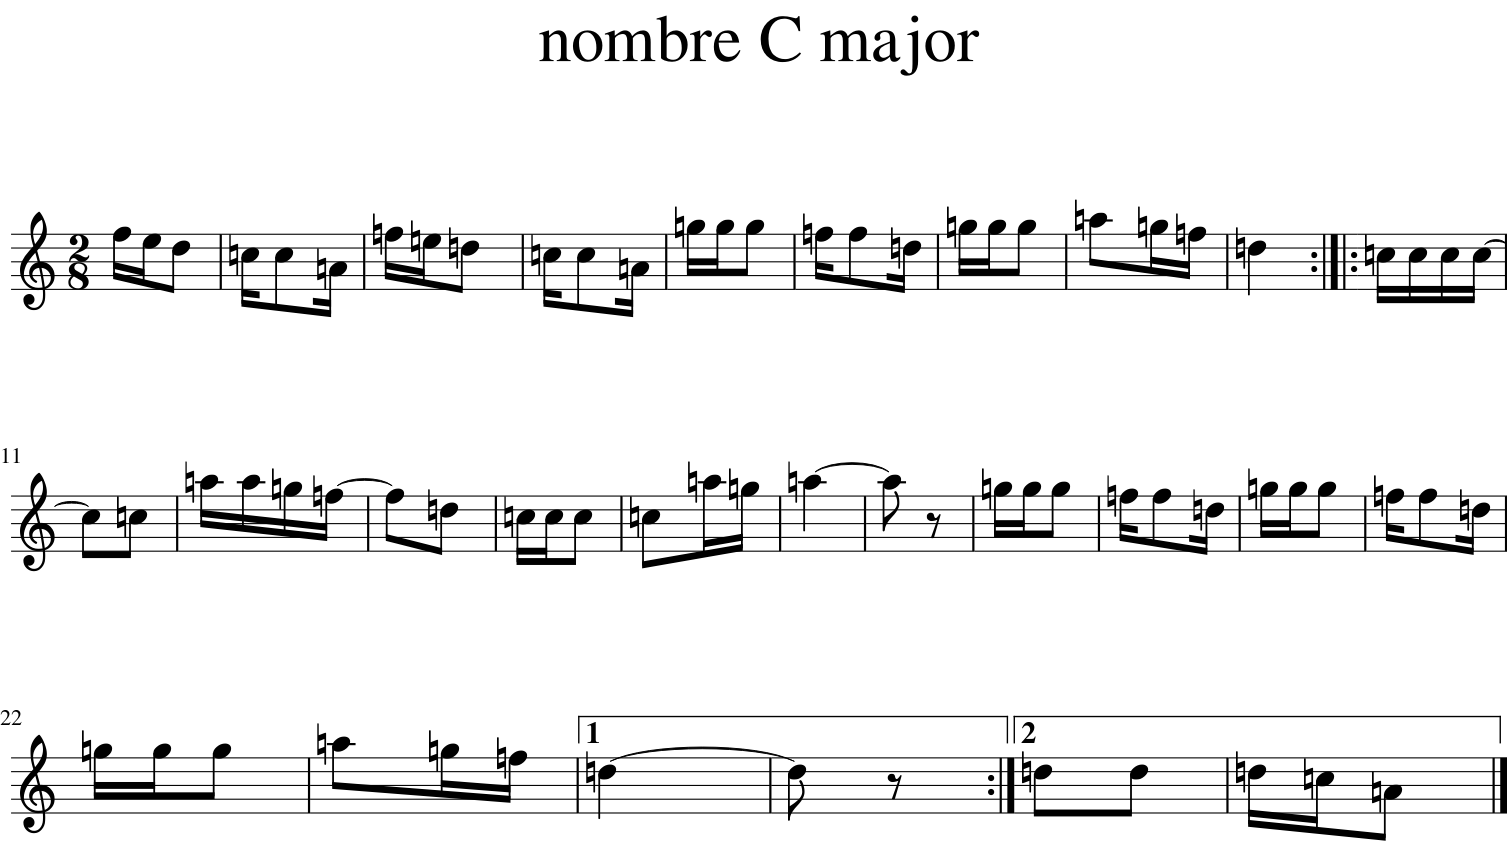

In [ ]:
graficarPartitura2(partitura,"nombre",vocabReves)